Data Base: https://www.kaggle.com/datasets/camnugent/california-housing-prices

# Análise de Preços de Imóveis na Califórnia

Este notebook demonstra um projeto completo de machine learning para análise de preços de imóveis na Califórnia. Seguiremos o fluxo padrão de um projeto de ML: carregamento de dados, exploração, preparação, modelagem e avaliação.

**Objetivos de Aprendizado:**
- Compreender o processo completo de um projeto de ML
- Aplicar técnicas de exploração e visualização de dados
- Implementar preparação de dados com Scikit-Learn
- Desenvolver um modelo preditivo para preços de imóveis

## Carregamento dos Dados

A função `load_housing_data()` realiza as seguintes operações:
1. Procura pelo arquivo **datasets/housing.tgz** no diretório atual
2. Se não encontrar:
   - Cria o diretório **datasets**
   - Baixa o arquivo do repositório GitHub **ageron/data**
   - Extrai o conteúdo criando **datasets/housing/housing.csv**
3. Carrega e retorna os dados em um DataFrame do Pandas

> **Nota**: O arquivo CSV contém informações sobre distritos censitários da Califórnia, onde cada linha representa um distrito com suas características demográficas e imobiliárias.

In [152]:
from pathlib import Path                                    # Para manipular caminhos de arquivos do sistema.
import pandas as pd                                         # Para manipulação de dados (DataFrames).
import tarfile                                              # Para extrair arquivos compactados (.tgz).
import urllib.request                                       # Para baixar arquivos de uma URL.
import matplotlib.pyplot as plt                             # Para gerar gráficos e visualizações.

def load_housing_data():
    csv_path = Path("datasets/housing/housing.csv")         # Define o caminho do arquivo de dados final.
    if csv_path.is_file():                                  # Checa se o arquivo CSV já existe.
        return pd.read_csv(csv_path)                        # Se sim, carrega e retorna o DataFrame.
        
    tarball_path = Path("datasets/housing.tgz")             # Define o caminho para o arquivo compactado.
    if not tarball_path.is_file():                          # Se o arquivo .tgz não foi baixado ainda...
        Path("datasets").mkdir(parents=True, exist_ok=True) # ...cria o diretório "datasets".
        url = "https://github.com/ageron/data/raw/main/housing.tgz" # URL dos dados.
        urllib.request.urlretrieve(url, tarball_path)       # Baixa o arquivo da URL.
    
    with tarfile.open(tarball_path) as housing_tarball:     # Usa o 'with' para abrir e garantir o fechamento do arquivo .tgz.
        housing_tarball.extractall(path="datasets")         # Extrai o conteúdo para a pasta "datasets".
        
    return pd.read_csv(csv_path)                            # Carrega e retorna o DataFrame do CSV extraído.


housing = load_housing_data()                               # Chama a função e armazena os dados na variável 'housing'.

## Exploração Inicial dos Dados

Vamos começar examinando a estrutura dos dados. Cada linha do DataFrame representa um distrito censitário da Califórnia, com os seguintes atributos:

**Atributos Geográficos:**
- **longitude, latitude**: Localização geográfica do distrito

**Atributos Demográficos:**
- **population**: População total do distrito
- **households**: Número de domicílios
- **median_income**: Renda mediana da região (em dezenas de milhares de dólares)

**Atributos Imobiliários:**
- **housing_median_age**: Idade mediana das casas no distrito
- **total_rooms**: Número total de cômodos
- **total_bedrooms**: Número total de quartos
- **median_house_value**: Valor mediano das casas (nosso atributo alvo)
- **ocean_proximity**: Categoria indicando proximidade com o oceano

> **Nota**: O atributo `ocean_proximity` não aparece nos histogramas por ser categórico (não-numérico). Analisaremos sua distribuição separadamente usando `value_counts()`.

Primeiro, vamos observar as cinco primeiras linhas usando o método `head()` do DataFrame:

In [153]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Cada linha representa um distrito. Existem **10 atributos** (nem todos são mostrados na captura de tela): `longitude`, `latitude`, `housing_median_age`, `total_rooms`, `total_bedrooms`, `population`, `households`, `median_income`, `median_house_value` e `ocean_proximity`.

***

O método `info()` é útil para obter uma descrição rápida dos dados, em particular o número total de linhas, o tipo de cada atributo e o número de valores não nulos:

In [154]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## Análise da Estrutura dos Dados

A saída do método `info()` nos revela informações importantes:

1. **Tamanho do Dataset**: 
   - 20.640 instâncias (distritos)
   - 10 atributos (características)

2. **Tipos de Dados**:
   - 9 atributos numéricos (tipo `float64`)
   - 1 atributo categórico (`ocean_proximity`)

3. **Valores Ausentes**:
   - `total_bedrooms`: 207 valores ausentes (1% dos dados)
   - Todos os outros atributos estão completos

**Impacto dos Valores Ausentes:**
- 1% de valores ausentes é relativamente baixo, mas ainda precisa ser tratado
- A maioria dos algoritmos de ML não consegue trabalhar com valores ausentes
- Precisaremos escolher uma estratégia: remoção, imputação ou descarte do atributo

Esta análise inicial já nos indica que precisaremos:
- Tratar os valores ausentes em `total_bedrooms`
- Converter o atributo categórico para formato numérico
- Considerar normalização dos dados devido às diferentes escalas

In [155]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [156]:

"""
ocean_proximity

<1H OCEAN    Menos de 1 hora do Oceano
INLAND       Interior ("Inland")
NEAR OCEAN   Próximos ao oceano
NEAR BAY     Perto de uma baía
ISLAND       Em uma ilha
"""


'\nocean_proximity\n\n<1H OCEAN    Menos de 1 hora do Oceano\nINLAND       Interior ("Inland")\nNEAR OCEAN   Próximos ao oceano\nNEAR BAY     Perto de uma baía\nISLAND       Em uma ilha\n'

In [157]:
#housing.describe()
housing.describe().round(1)  #1.0 em Median_income é igual a $10.000

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.0,20640.0,20640.0,20640.0,20433.0,20640.0,20640.0,20640.0,20640.0
mean,-119.6,35.6,28.6,2635.8,537.9,1425.5,499.5,3.9,206855.8
std,2.0,2.1,12.6,2181.6,421.4,1132.5,382.3,1.9,115395.6
min,-124.4,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1447.8,296.0,787.0,280.0,2.6,119600.0
50%,-118.5,34.3,29.0,2127.0,435.0,1166.0,409.0,3.5,179700.0
75%,-118.0,37.7,37.0,3148.0,647.0,1725.0,605.0,4.7,264725.0
max,-114.3,42.0,52.0,39320.0,6445.0,35682.0,6082.0,15.0,500001.0


As linhas `count` (contagem), `mean` (média), `min` (mínimo) e `max` (máximo) são autoexplicativas. Note que os valores nulos são ignorados (assim, por exemplo, a contagem de `total_bedrooms` é 20.433, e não 20.640). A linha `std` mostra o desvio padrão (*standard deviation*), que mede quão dispersos os valores estão.

**Entendendo os Percentis:**
As linhas `25%`, `50%` e `75%` mostram os percentis correspondentes. Um percentil indica o valor abaixo do qual uma determinada porcentagem de observações se encontra:
- **25º percentil (Q1)**: 25% dos valores estão abaixo deste ponto
- **50º percentil (mediana)**: 50% dos valores estão abaixo deste ponto
- **75º percentil (Q3)**: 75% dos valores estão abaixo deste ponto

**Exemplo prático**: Para `housing_median_age`:
- 25% dos distritos têm casas com menos de 18 anos
- 50% dos distritos têm casas com menos de 29 anos
- 75% dos distritos têm casas com menos de 37 anos

Outra maneira rápida de ter uma noção do tipo de dados é plotar um histograma para cada atributo numérico. Um histograma mostra o número de instâncias (no eixo vertical) que possuem uma determinada faixa de valores (no eixo horizontal).

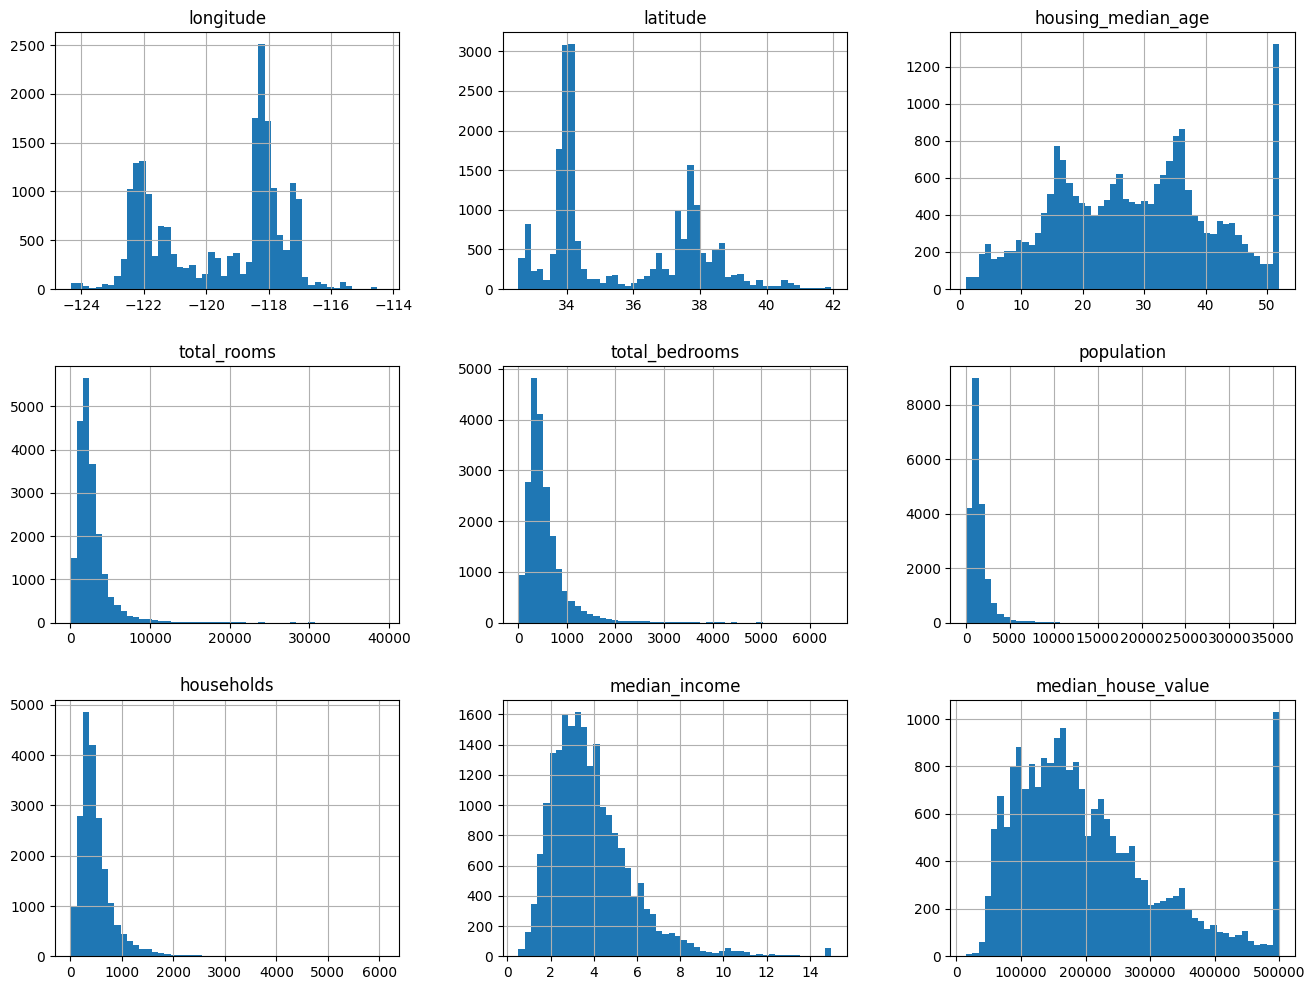

In [158]:
housing.hist(bins=50, figsize=(16, 12))
plt.show()

## Análise das Distribuições

A visualização dos histogramas revela características importantes dos nossos dados:

### 1. Atributos Pré-processados
- **Renda Mediana (`median_income`)**: 
  - Escalonada entre 0.5 e 15
  - Um valor de 3.0 representa $30,000 (valores divididos por 10,000)
  - Limitação artificial pode afetar a análise de áreas de alta renda

- **Valor Mediano do Imóvel (`median_house_value`)**:
  - Limitado em $500,000 (observe a linha vertical no histograma)
  - Esta limitação é um **problema crítico** pois:
    1. O modelo nunca aprenderá a prever valores acima deste limite
    2. Pode distorcer a relação real entre as variáveis
    3. Prejudica previsões em áreas de alto valor imobiliário

### 2. Distribuições Assimétricas
Vários atributos apresentam distribuição assimétrica à direita (cauda longa):
- `median_income`
- `total_rooms`
- `total_bedrooms`
- `population`
- `households`

**Por que isso é importante?** Esta assimetria pode prejudicar o desempenho de alguns algoritmos de ML que assumem distribuição normal. Possíveis soluções:
- Transformação logarítmica
- Normalização dos dados
- Uso de algoritmos robustos a distribuições não-normais

### 3. Correlações Visuais
Os histogramas também sugerem possíveis correlações:
- `total_rooms` e `total_bedrooms` parecem ter distribuições similares
- `population` e `households` também mostram padrões semelhantes

### �� Criando o Conjunto de Teste

Antes de explorar os dados a fundo, é crucial separar um **conjunto de teste**.

**Por quê?** Para evitar o **viés de espionagem de dados** (*data snooping bias*). Nosso cérebro é uma máquina de encontrar padrões. Se olharmos para o conjunto de teste, podemos acidentalmente identificar padrões e escolher um modelo que se ajuste bem a esses dados específicos. Isso levaria a uma avaliação de desempenho excessivamente otimista, e o modelo falharia em produção.

**O que é o Data Snooping Bias?**
- É quando fazemos decisões baseadas em informações que não estarão disponíveis em produção
- Pode levar a overfitting e avaliações irreais de performance
- É um dos erros mais comuns em projetos de ML

**Como?** Vamos separar aleatoriamente 20% dos dados e guardá-los. Só usaremos esse conjunto no final, para avaliar o desempenho do nosso modelo final.

In [159]:
import numpy as np                                           # Biblioteca para computação numérica, usada aqui para embaralhar os índices.

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))      # Gera uma sequência aleatória dos índices do DataFrame.
    test_set_size = int(len(data) * test_ratio)              # Calcula o tamanho (número de linhas) do conjunto de teste.
    test_indices = shuffled_indices[:test_set_size]          # Seleciona os primeiros índices da sequência aleatória para o teste.
    train_indices = shuffled_indices[test_set_size:]         # Seleciona os índices restantes para o treino.
    return data.iloc[train_indices], data.iloc[test_indices] # Retorna os conjuntos de treino e teste fatiando o DataFrame original.

In [160]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)

In [161]:
len(train_set)

16512

In [162]:
len(test_set)

4128

### ⚙️ Criando uma Divisão Estável de Treino/Teste

A abordagem aleatória anterior tem uma falha: a cada execução, um novo conjunto de teste é gerado. Com o tempo, o modelo acabaria "vendo" todos os dados, o que anula o propósito da separação.

**Problemas da Divisão Aleatória Simples:**
- **Não reprodutível**: Diferentes execuções geram diferentes divisões
- **Instabilidade**: Novos dados podem mudar completamente a divisão
- **Vazamento de dados**: Com o tempo, todos os dados acabam sendo "vistos"

**A Solução Robusta:**
Vamos usar o **identificador único** de cada instância para decidir se ela vai para o conjunto de treino ou teste. A ideia é calcular um *hash* para cada identificador. Se o *hash* estiver abaixo de um certo limite (ex: 20% do valor máximo), a instância vai para o conjunto de teste.

Isso garante que a divisão seja **estável e consistente** em múltiplas execuções, mesmo que novos dados sejam adicionados ao dataset. Uma instância que estava no treino nunca irá para o teste.

In [163]:
from zlib import crc32                                      # Função para calcular um hash (checksum) de 32 bits.
import numpy as np                                          # Usado para garantir um tipo de dado consistente para o ID.

def is_id_in_test_set(identifier, test_ratio):
    # Compara o hash do ID com um limiar para decidir se ele pertence ao conjunto de teste.
    # Esta abordagem garante que a divisão seja estável (um mesmo ID sempre cairá no mesmo conjunto).
    return crc32(np.int64(identifier)) < test_ratio * 2**32

"""def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]                                   # Seleciona a coluna que serve como identificador único.
    # Aplica a função a cada ID, gerando uma máscara booleana (True se for para o teste).
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    # Usa a máscara para fatiar o DataFrame em treino (`~` nega a máscara) e teste.
    return data.loc[~in_test_set], data.loc[in_test_set]"""


def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set_list = []  # 1. Criamos uma lista vazia para guardar os resultados

    # 2. Usamos um laço 'for' para passar por cada identificador, um por um
    for id_ in ids:
        # 3. Para cada id, chamamos a função e guardamos o resultado (True ou False) na lista
        resultado = is_id_in_test_set(id_, test_ratio)
        in_test_set_list.append(resultado)

    # Ao final, 'in_test_set_list' será uma lista como [False, True, False, False, True, ...]
    
    # Criamos a máscara booleana com o índice correto
    in_test_set = pd.Series(in_test_set_list, index=data.index)

    # 4. Usamos essa lista para separar os dados de treino e teste
    dados_de_treino = data.loc[in_test_set == False]  # Onde o resultado foi False
    dados_de_teste = data.loc[in_test_set == True]    # Onde o resultado foi True
    
    return dados_de_treino, dados_de_teste

1.  **`is_id_in_test_set`**:
    Esta função funciona como um **juiz**. Ela olha para **um único ID** e decide se ele pertence ao grupo de teste ou não, retornando `True` ou `False`.

2.  **`split_data_with_id_hash`**:
    Esta função é o **organizador**. Ela usa o "juiz" (a função anterior) para perguntar, linha por linha, a qual grupo cada ID pertence. No final, ela **separa o conjunto de dados completo** nos dois grupos: treino e teste.

In [164]:
# Adiciona o índice atual do DataFrame como uma nova coluna chamada "index".
# Isso garante que cada linha tenha um identificador único e estável.
housing_with_id = housing.reset_index()

# Usa a função de divisão por hash para separar os dados em treino e teste (20%).
# A coluna "index" é usada como o identificador para a divisão estável.
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

### 🆔 Definindo um Identificador Único e Estável

Para que a divisão por *hash* funcione, precisamos de um identificador único e que não mude com o tempo.

* **Usar o índice da linha:** Esta é a opção mais simples, mas só funciona se garantirmos que novos dados sejam sempre adicionados ao final e que nenhuma linha seja deletada.

* **Criar um ID com características estáveis:** Se não podemos garantir a estabilidade do índice, a melhor alternativa é criar um ID combinando as características mais estáveis do dataset. No nosso caso, a **latitude** e a **longitude** de um distrito são perfeitas, pois são garantidas de não mudar. Vamos usar essa abordagem para criar um ID robusto para cada distrito.

In [165]:
# Cria um ID estável combinando as coordenadas geográficas (longitude e latitude).
# Isso evita que a divisão mude se as linhas do dataset forem reordenadas.
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]

# Divide os dados novamente, desta vez usando o novo ID geográfico para o hash.
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

### 🚀 Dividindo o Dataset com a Função `train_test_split` do Scikit-Learn

O Scikit-Learn oferece uma função simples e poderosa para dividir datasets: a `train_test_split`. Ela faz um trabalho muito parecido com a função que criamos manualmente, mas com algumas vantagens importantes:

* **Reprodutibilidade com `random_state`**: Possui um parâmetro `random_state` que funciona como uma semente aleatória, garantindo que a divisão dos dados seja sempre a mesma em todas as execuções do código.

* **Divisão Sincronizada**: Você pode passar múltiplos dataframes para a função (como os dados de treino `X` e os rótulos `y`), e ela garantirá que a divisão seja feita usando os mesmos índices para todos. Isso é extremamente útil para manter a correspondência entre as características e seus respectivos alvos.

In [166]:
from sklearn.model_selection import train_test_split    # Importa a função padrão do Scikit-learn para dividir dados.

# Divide os dados (20% para teste) de forma aleatória, mas reprodutível (random_state=42).
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

### Sampling Estratificado: Garantindo um Conjunto de Teste Representativo

Amostragem puramente aleatória pode ser um problema, especialmente em datasets menores, pois corre o risco de criar um conjunto de teste que não representa bem a população total. Isso é conhecido como **viés de amostragem**.

**Por que a Amostragem Aleatória Simples Pode Falhar?**
- **Distribuição desigual**: Algumas categorias podem ficar sub-representadas
- **Casos extremos**: Categorias raras podem não aparecer no teste
- **Viés de seleção**: O teste pode não refletir a população real

**Analogia com Pesquisas Eleitorais:**
Pense em uma empresa de pesquisa de opinião: ela não liga para 1.000 pessoas aleatórias. Em vez disso, ela garante que sua amostra de 1.000 pessoas reflita a demografia da população inteira (por exemplo, a proporção de homens e mulheres).

#### A Solução: Amostragem Estratificada 📋

Para evitar esse viés, usaremos a **amostragem estratificada**. O processo consiste em:
1. Dividir a população em subgrupos homogêneos chamados **estratos** (*strata*).
2. Retirar um número proporcional de instâncias de cada estrato para o conjunto de teste.

Isso garante que o conjunto de teste seja uma "miniatura" fiel de todo o conjunto de dados.

#### Aplicando ao Nosso Problema

Os especialistas nos disseram que a **renda mediana** é um atributo crucial para prever os preços das casas. Portanto, precisamos garantir que nosso conjunto de teste represente bem as diferentes faixas de renda do dataset completo.

Como a renda mediana é um atributo numérico contínuo, nosso primeiro passo será criar um **atributo de categoria de renda** para que possamos realizar a amostragem estratificada com base nele.

In [167]:
# Cria uma categoria de renda (income_cat) dividindo a renda mediana em 5 faixas.
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [168]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


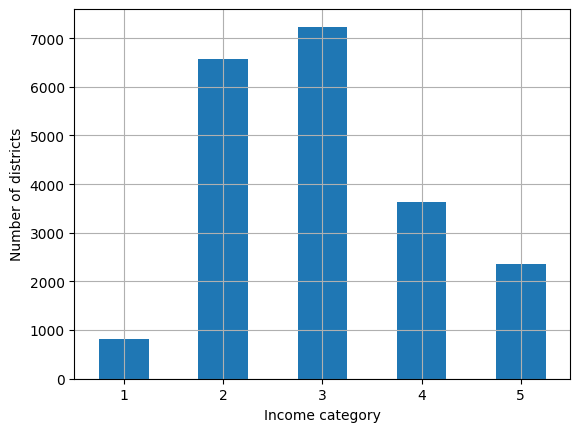

In [169]:
# Conta os valores, ordena e plota um gráfico de barras com grade e sem rotação de texto.
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")                       # Define o rótulo do eixo X.
plt.ylabel("Number of districts")                   # Define o rótulo do eixo Y.
plt.show()                                          # Exibe o gráfico final.

### ✂️ Usando as Classes de Divisão (*Splitter Classes*) do Scikit-Learn

O Scikit-Learn facilita a amostragem estratificada através das **classes de divisão** (*splitter classes*), disponíveis no pacote `sklearn.model_selection`.

Cada uma dessas classes implementa uma estratégia diferente para dividir os dados. Elas funcionam através de um método `split()`, que retorna um iterador gerando os índices para os conjuntos de treino e teste de acordo com a estratégia escolhida.

É importante notar que o método `split()` não retorna os dados em si, mas sim os **índices** de cada instância para os conjuntos de treino e teste.

A capacidade de gerar múltiplas divisões é útil para estimar o desempenho do modelo de forma mais robusta, uma técnica que exploraremos mais tarde com o nome de **validação cruzada** (*cross-validation*).

O código a seguir, por exemplo, gera 10 divisões estratificadas diferentes do mesmo dataset:

In [170]:
from sklearn.model_selection import StratifiedShuffleSplit

# Configura o divisor para gerar 10 splits estratificados, com 20% dos dados para teste.
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []                                          # Lista para armazenar os 10 pares [treino, teste].

# Itera 10 vezes, gerando índices de treino/teste que mantêm a proporção das categorias de renda.
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]          # Cria o conjunto de treino da iteração atual.
    strat_test_set_n = housing.iloc[test_index]            # Cria o conjunto de teste da iteração atual. (Validação)
    strat_splits.append([strat_train_set_n, strat_test_set_n]) # Adiciona o par [treino, teste] à lista.

In [171]:
# Seleciona o primeiro par de [treino, teste] da lista de 10 splits gerados.
strat_train_set, strat_test_set = strat_splits[0]

Como a amostragem estratificada é bastante comum, existe uma maneira mais curta de obter uma única divisão usando a função `train_test_split()` com o argumento `stratify`:

In [172]:
# Realiza a mesma divisão estratificada (20% para teste) em uma única chamada de função.
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [173]:
# Calcula a proporção de cada categoria de renda no conjunto de teste.
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

### ✅ Validando a Amostragem Estratificada

No conjunto de teste gerado com **amostragem estratificada** e em um conjunto de teste gerado com **amostragem puramente aleatória**.

Como você pode ver, o teste gerado com amostragem estratificada tem proporções de categoria de renda quase idênticas às do conjunto de dados completo, enquanto o conjunto de teste gerado com amostragem puramente aleatória ficou distorcido (*skewed*).

In [174]:
# Remove a coluna "income_cat" dos DataFrames de treino e teste, pois ela só foi usada para a amostragem.
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

Dedicamos um bom tempo à geração do conjunto de teste por um bom motivo: esta é uma parte **crítica**, embora muitas vezes negligenciada, de um projeto de machine learning. Muitas dessas ideias serão úteis mais tarde quando discutirmos a validação cruzada. 

Agora é hora de avançar para a próxima etapa: **explorar os dados**.

## 🗺️ Explore e Visualize os Dados para Obter Insights

Até agora, você deu apenas uma olhada superficial nos dados para ter uma compreensão geral. O objetivo agora é ir um pouco mais a fundo.

**Importante**: Certifique-se de que você deixou o conjunto de teste de lado e está explorando **apenas o conjunto de treinamento**. Além disso, se o conjunto de treinamento for muito grande, você pode querer amostrar um "conjunto de exploração" para tornar as manipulações fáceis e rápidas durante esta fase. Neste caso, o conjunto de treinamento é pequeno, então você pode trabalhar diretamente no conjunto completo.

Como você vai experimentar várias transformações, é uma boa prática criar uma cópia do conjunto de treinamento original para poder reverter a ele mais tarde:

In [175]:
# Cria uma cópia do conjunto de treino para não estragar o original durante a exploração.
housing = strat_train_set.copy()

Como o dataset inclui informações geográficas (latitude e longitude), é uma boa ideia criar um gráfico de dispersão (*scatterplot*) de todos os distritos para visualizar os dados (Figura 2-11):

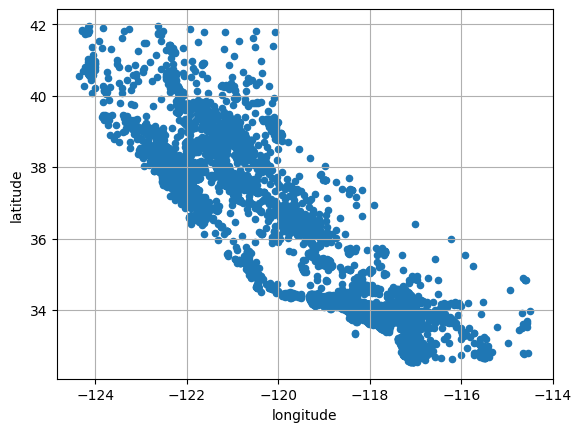

In [176]:
# Cria um gráfico de dispersão para visualizar a distribuição geográfica dos dados.
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show()                                          # Exibe o gráfico.

Este gráfico se parece com a Califórnia, mas fora isso é difícil ver qualquer padrão em particular.

Definir a opção `alpha` para `0.2` torna muito mais fácil visualizar os locais onde há uma alta densidade de pontos de dados (Figura 2-12):

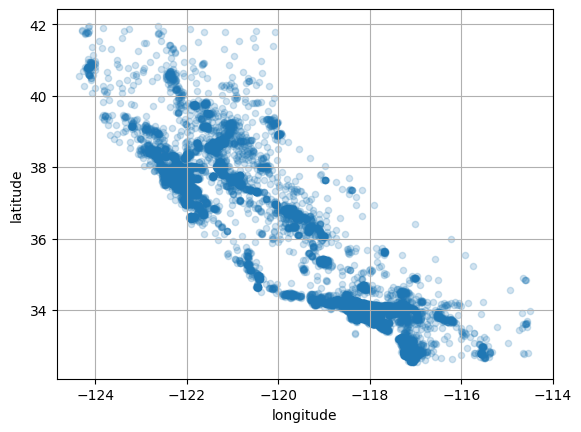

In [177]:
# O 'alpha=0.2' (transparência) ajuda a visualizar a densidade, ou seja, onde os pontos se concentram.
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()                                          # Exibe o gráfico.

Isso está bem melhor: agora você pode ver claramente as áreas de alta densidade, como a Bay Area e as regiões de Los Angeles e San Diego, além de uma longa linha de áreas com densidade razoavelmente alta no Vale Central (em particular, ao redor de Sacramento e Fresno).

Nossos cérebros são muito bons em identificar padrões em imagens, mas pode ser necessário brincar com os parâmetros de visualização para fazer com que os padrões se destaquem.

***

### 🗺️ Visualizando os Preços das Casas no Mapa

A seguir, vamos analisar os preços das casas (Figura 2-13). O **raio** de cada círculo representará a **população** do distrito (opção `s`), e a **cor** representará o **preço** (opção `c`). Usaremos um mapa de cores (`cmap`) predefinido chamado `jet`, que vai do **azul** (valores baixos) ao **vermelho** (preços altos):

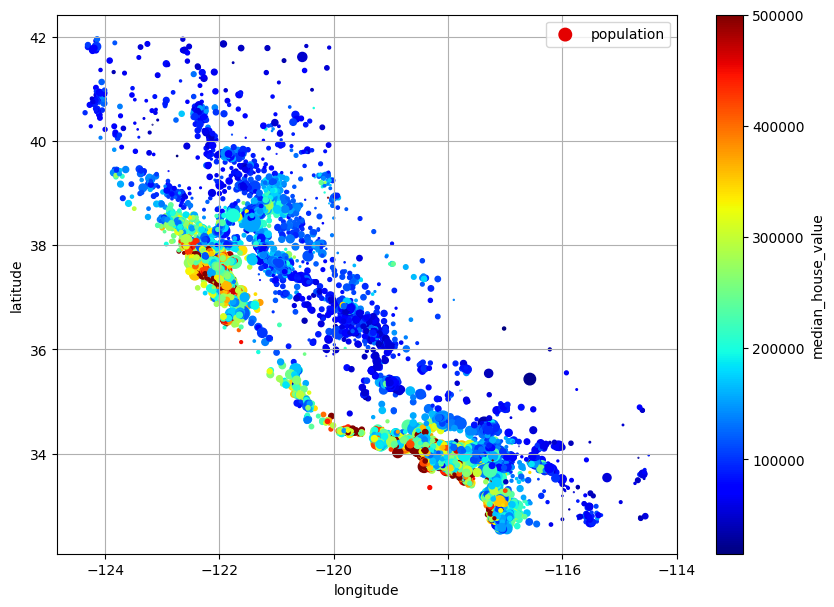

In [178]:
# Gráfico mais informativo, adicionando duas dimensões:
# s: o tamanho (size) de cada círculo representa a população do distrito.
# c: a cor (color) representa a mediana do valor da casa (median_house_value).
# cmap="jet": define a escala de cores, de azul (valores baixos) a vermelho (valores altos).
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

Esta imagem confirma que os preços das casas estão muito relacionados à **localização** (por exemplo, perto do oceano) e à **densidade populacional**, como você provavelmente já sabia. Um algoritmo de *clustering* deve ser útil para detectar os principais agrupamentos e para adicionar novas características que meçam a proximidade aos centros desses agrupamentos. O atributo de proximidade do oceano também pode ser útil, embora no norte da Califórnia os preços das casas nos distritos costeiros não sejam tão altos, então não é uma regra simples.

***

## 📊 Procurando por Correlações

Como o conjunto de dados não é muito grande, você pode calcular facilmente o **coeficiente de correlação padrão** (também chamado de **r de Pearson**) entre cada par de atributos usando o método `corr()`:

In [179]:
# Calcular correlação apenas nas colunas numéricas
corr_matrix = housing.select_dtypes(include=[np.number]).corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

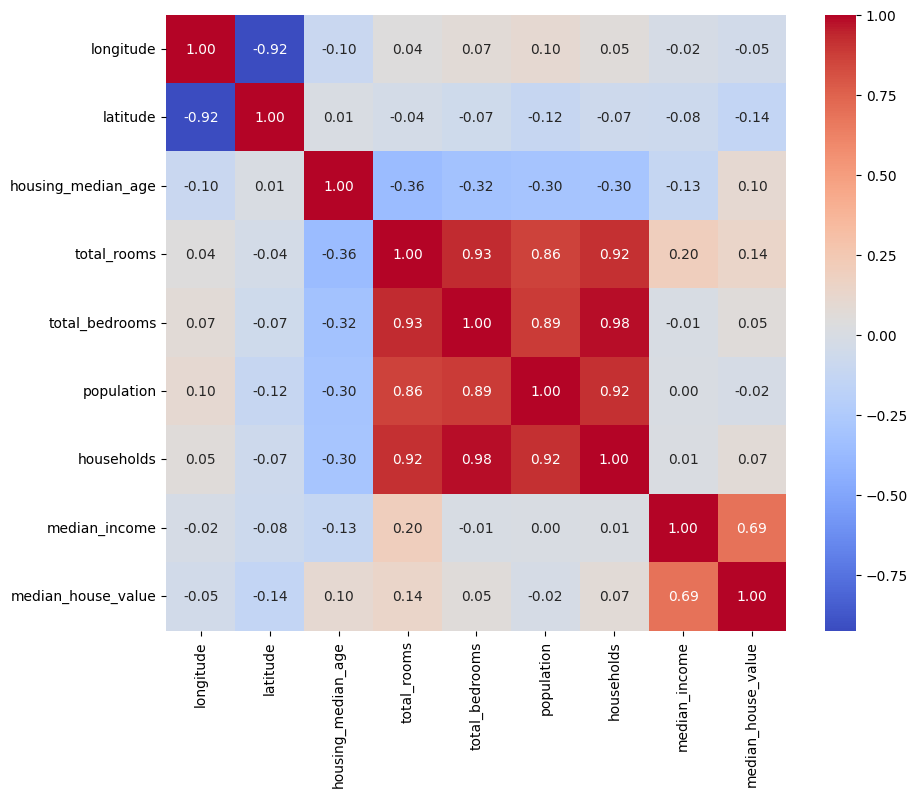

In [180]:
import seaborn as sns

plt.figure(figsize=(10, 8))  # Define o tamanho da figura
sns.heatmap(housing.select_dtypes(include=['float64', 'int64']).corr(), annot=True, fmt=".2f", cmap="coolwarm")

plt.show()

### Entendendo o Coeficiente de Correlação 📈

O coeficiente de correlação varia de **–1 a 1**:

* **Perto de 1**: Significa que há uma forte **correlação positiva**. Por exemplo, o valor mediano da casa tende a subir quando a renda mediana sobe.
* **Perto de –1**: Significa que há uma forte **correlação negativa**. Você pode ver uma pequena correlação negativa entre a latitude e o valor mediano da casa (ou seja, os preços têm uma leve tendência a diminuir à medida que se vai para o norte).
* **Perto de 0**: Significa que não há **correlação linear**.

***

### Visualizando Correlações com `scatter_matrix`

Outra maneira de verificar a correlação entre atributos é usar a função `scatter_matrix()` do Pandas, que plota cada atributo numérico contra todos os outros atributos numéricos.

Como temos 11 atributos numéricos, isso resultaria em 11² = 121 gráficos, o que não caberia em uma página. Portanto, vamos nos concentrar em alguns atributos promissores que parecem mais correlacionados com o valor mediano da moradia (Figura 2-14):

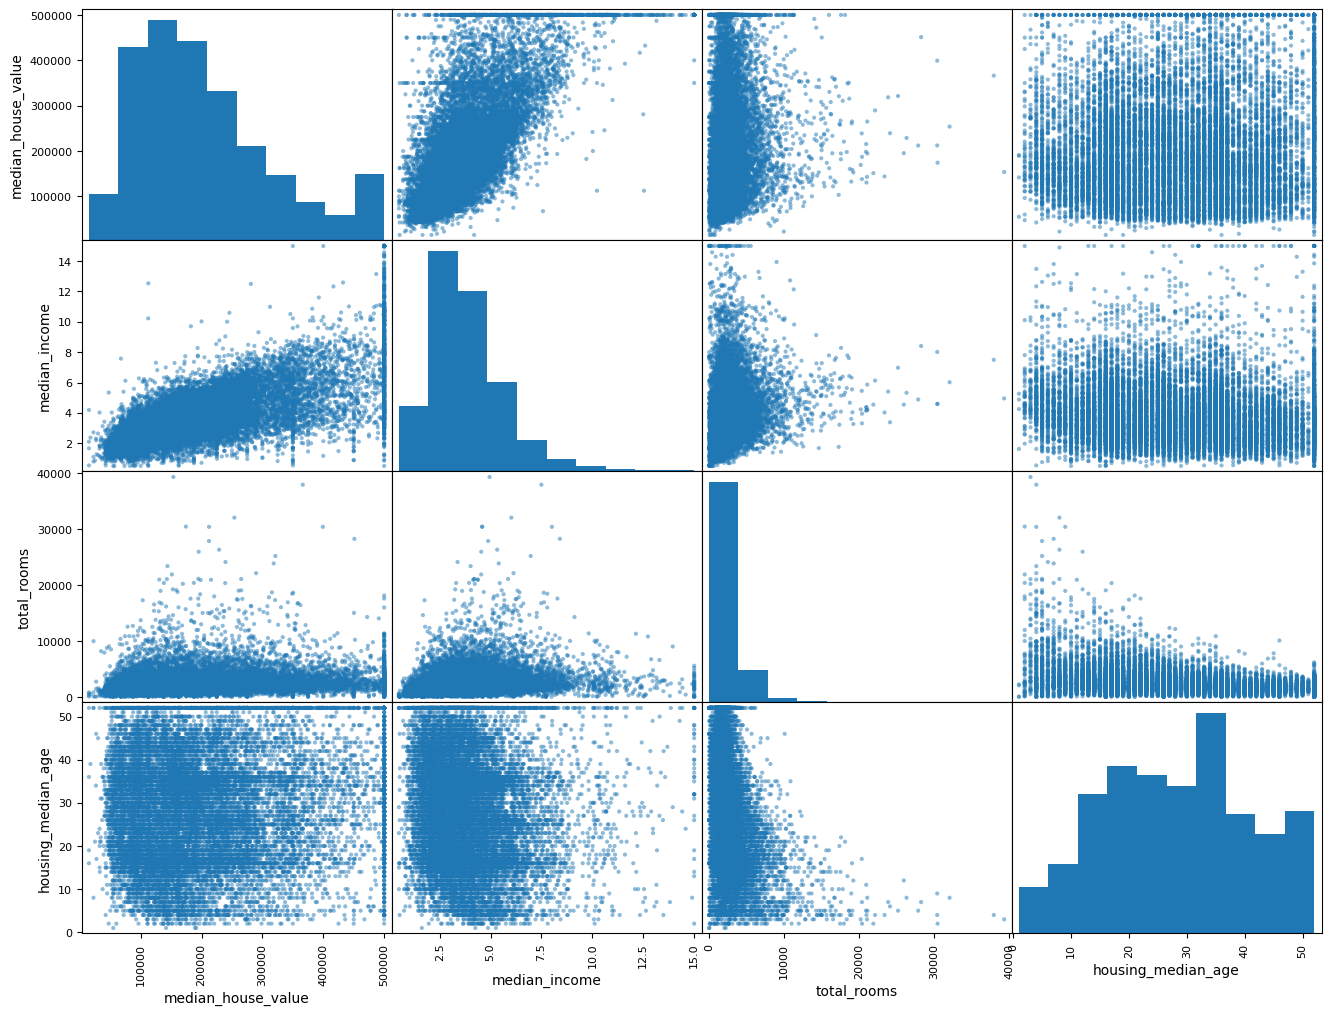

In [181]:
from pandas.plotting import scatter_matrix

# Define a lista de atributos que queremos comparar entre si.
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]

# Cria uma matriz de gráficos de dispersão para verificar a correlação entre os atributos.
# Na diagonal, em vez de um gráfico de dispersão, ele mostra um histograma de cada atributo.
scatter_matrix(housing[attributes], figsize=(16, 12))
plt.show()                                          # Exibe a matriz de gráficos.

A diagonal principal estaria cheia de linhas retas se o Pandas plotasse cada variável contra si mesma, o que não seria muito útil. Em vez disso, o Pandas exibe um **histograma** de cada atributo (outras opções estão disponíveis; veja a documentação do Pandas para mais detalhes).

Analisando os gráficos de dispersão da correlação, parece que o atributo mais promissor para prever o valor mediano da casa é a **renda mediana**.

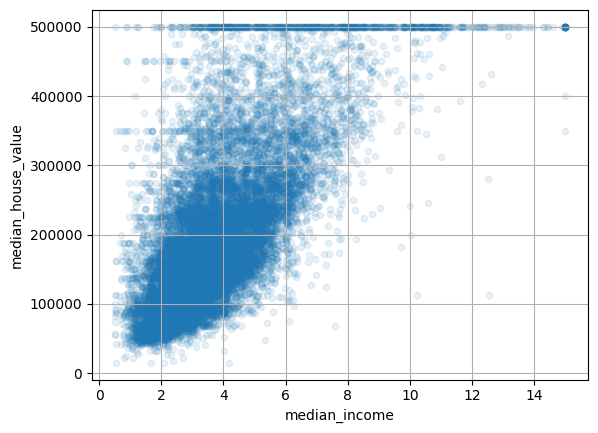

In [182]:
# Focando na correlação mais promissora: renda mediana vs. valor mediano da casa.
# O 'alpha=0.1' ajuda a ver onde os pontos de dados estão mais densos.
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
plt.show()                                          # Exibe o gráfico.

### Análise do Gráfico de Renda vs. Preço

O gráfico mostra algumas coisas importantes:
1.  **Tendência Clara**: Há uma nítida tendência de alta, e os pontos não estão excessivamente dispersos.
2.  **Limite de Preço Visível**: O limite de preço (*price cap*) que notamos anteriormente é claramente visível como uma linha horizontal em **$500.000**.
3.  **Peculiaridades nos Dados**: O gráfico também revela outras linhas horizontais menos óbvias, perto de **$450.000**, **$350.000** e **$280.000**. 

Essas linhas retas são peculiaridades nos dados (*data quirks*). Para evitar que os algoritmos aprendam a reproduzir esses padrões artificiais, pode ser uma boa ideia **remover os distritos correspondentes** antes de treinar o modelo.

### 🧪 Experimentando com Combinações de Atributos

Até aqui, a exploração dos dados nos deu vários insights: identificamos peculiaridades para limpar, encontramos correlações importantes e notamos distribuições assimétricas que podemos transformar (ex: com logaritmo).

Uma última etapa de exploração, e muito importante, antes de preparar os dados para os algoritmos de Machine Learning é experimentar **combinações de atributos**. Às vezes, a combinação de características pode ser muito mais poderosa e informativa do que as características isoladas.

Por exemplo:
* O **número total de cômodos** em um distrito não é tão útil se não soubermos quantas famílias existem. O que realmente queremos é o número de **cômodos por família**.
* Da mesma forma, o **total de quartos** por si só não é muito útil; provavelmente queremos compará-lo com o número de cômodos.
* A **população por família** também parece ser uma combinação de atributos interessante para se analisar.

Vamos criar esses novos atributos da seguinte forma:

In [183]:
# Etapa de "Feature Engineering": criação de novos atributos a partir dos existentes.
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]      # Calcula a média de cômodos por domicílio.
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]    # Calcula a proporção de quartos no total de cômodos.
housing["people_per_house"] = housing["population"] / housing["households"]     # Calcula a média de moradores por domicílio.

In [184]:
# Calcula a matriz de correlação de Pearson para todos os atributos numéricos do DataFrame.
corr_matrix = housing.select_dtypes(include=[np.number]).corr()

# Exibe a correlação de cada atributo com o "median_house_value", ordenando da mais forte para a mais fraca.
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

### ✅ Resultados da Combinação de Atributos

Ótimos resultados! O novo atributo `bedrooms_ratio` (proporção de quartos) é muito mais correlacionado com o valor mediano da casa do que o total de cômodos ou de quartos. Aparentemente, casas com uma menor proporção de quartos para cômodos tendem a ser mais caras. O atributo `rooms_per_household` (cômodos por família) também é mais informativo do que o total de cômodos — obviamente, quanto maiores as casas, mais caras elas são.

***

### O Processo é Iterativo 🔄

Esta rodada de exploração não precisa ser absolutamente completa; o objetivo é começar com o pé direito e obter rapidamente insights que o ajudarão a obter um primeiro protótipo razoavelmente bom. Mas este é um **processo iterativo**: assim que você tiver um protótipo funcionando, poderá analisar seus resultados para obter mais insights e voltar a esta etapa de exploração.

## 🤖 Preparando os Dados para os Algoritmos de Machine Learning

Agora é hora de escrever funções para realizar as transformações que identificamos durante a exploração. A vantagem disso é que:

**Benefícios da Automação:**
- **Reutilização**: Você poderá usar essas mesmas funções no seu sistema em produção
- **Consistência**: Garante que novos dados sejam processados da mesma forma
- **Experimentação**: Facilita testar diferentes transformações
- **Manutenibilidade**: Mudanças podem ser feitas em um só lugar

**Fluxo de Preparação:**
1. Limpar dados (valores ausentes, outliers)
2. Converter atributos categóricos
3. Escalonar/normalizar atributos numéricos
4. Criar novas features derivadas

Mas primeiro, reverta para um conjunto de treinamento limpo (copiando o `strat_train_set` mais uma vez). Você também deve separar os **preditores** (features) dos **rótulos** (labels), pois não necessariamente queremos aplicar as mesmas transformações aos preditores e aos valores alvo (note que o `drop()` cria uma cópia dos dados e não afeta o `strat_train_set`):

In [185]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## �� Limpeza de Dados

Most machine learning algorithms cannot work with missing features, so you'll need to take care of these. For example, you noticed earlier that the total_bedrooms attribute has some missing values. You have three options to fix this:

**Opções para Tratar Valores Ausentes:**

1. **Remover as instâncias** (`dropna()`): 
   - Vantagem: Simples e rápido
   - Desvantagem: Perda de dados (207 instâncias = 1% do dataset)

2. **Remover o atributo** (`drop()`): 
   - Vantagem: Elimina completamente o problema
   - Desvantagem: Perda de informação potencialmente útil

3. **Imputação** (`fillna()`): 
   - Vantagem: Preserva todos os dados
   - Desvantagem: Pode introduzir viés se não for bem feita

**Estratégias de Imputação:**
- **Mediana**: Robusta a outliers
- **Média**: Sensível a outliers
- **Moda**: Para dados categóricos
- **Valor constante**: Quando faz sentido no contexto

You can accomplish these easily using the Pandas DataFrame's dropna(), drop(), and fillna() methods:

In [186]:
# Opção 1: Remove as linhas (distritos) onde "total_bedrooms" é nulo.
housing.dropna(subset=["total_bedrooms"], inplace=True)

# Opção 2: Remove a coluna "total_bedrooms" por completo.
housing.drop("total_bedrooms", axis=1)

# Opção 3 (passo 1): Calcula a mediana da coluna "total_bedrooms".
median = housing["total_bedrooms"].median()

# Opção 3 (passo 2): Preenche os valores nulos (NaN) com a mediana calculada.
housing["total_bedrooms"].fillna(median, inplace=True)

C:\Users\estev\AppData\Local\Temp\ipykernel_24680\136532266.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing["total_bedrooms"].fillna(median, inplace=True)


Você decide seguir com a opção 3, pois é a menos destrutiva, mas em vez do código anterior, você usará uma classe muito útil do Scikit-Learn: `SimpleImputer`.

O benefício é que ela **armazenará o valor da mediana** de cada característica. Isso tornará possível preencher (*impute*) os valores faltantes não apenas no conjunto de treino, mas também no conjunto de validação, no de teste e em quaisquer novos dados alimentados ao modelo.

Para usá-la, primeiro você precisa criar uma instância de `SimpleImputer`, especificando que deseja substituir os valores faltantes de cada atributo pela **mediana** daquele atributo:

In [187]:
from sklearn.impute import SimpleImputer                   # Importa a classe do Scikit-learn para tratar dados ausentes (imputação).

# Cria uma instância do imputer, definindo a estratégia de preenchimento como a "mediana".
imputer = SimpleImputer(strategy="median")

# O imputer só funciona com dados numéricos, então separamos as colunas numéricas do DataFrame.
housing_num = housing.select_dtypes(include=[np.number])

# "Treina" o imputer nos dados numéricos. Ele calcula a mediana de cada coluna e a armazena internamente.
imputer.fit(housing_num)

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


Como a mediana só pode ser calculada em atributos numéricos, você precisa criar uma cópia dos dados apenas com os atributos numéricos (isso excluirá o atributo de texto `ocean_proximity`):

Agora você pode "treinar" (*fit*) a instância do imputer nos dados de treinamento usando o método `fit()`:

O imputer armazenou as medianas calculadas em sua variável de instância `statistics_`.

Apesar de apenas o atributo `total_bedrooms` ter valores faltantes, você não pode ter certeza de que não haverá valores faltantes em novos dados quando o sistema estiver em produção. Portanto, é mais seguro aplicar o imputer a **todos os atributos numéricos**:

Agora você pode usar este imputer "treinado" para **transformar** o conjunto de treinamento, substituindo os valores faltantes pelas medianas aprendidas:

***

#### 💡 Outras Estratégias de Imputação

Valores faltantes também podem ser substituídos por:
* A **média** (`strategy="mean"`)
* O **valor mais frequente** (`strategy="most_frequent"`)
* Um **valor constante** (`strategy="constant", fill_value=…`)

As duas últimas estratégias também funcionam para dados não numéricos.

In [188]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.5   ,  434.    , 1167.    ,
        408.5   ,    3.5409])

In [189]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2125.5   ,  434.    , 1167.    ,
        408.5   ,    3.5409])

In [190]:
X = imputer.transform(housing_num)

### ⚠️ Convertendo de Volta para um DataFrame

Um detalhe importante: os transformadores do Scikit-Learn, como o `SimpleImputer`, retornam um **array NumPy** como saída, mesmo quando a entrada é um DataFrame do Pandas.

Isso significa que a nossa variável de saída não terá mais os nomes das colunas ou o índice. Felizmente, é fácil resolver isso. Vamos "embrulhar" o array NumPy de volta em um DataFrame, recuperando as colunas e o índice do nosso DataFrame numérico original:

In [191]:
# O resultado do imputer é um array NumPy, então o convertemos de volta para um DataFrame,
# garantindo que as colunas e os índices originais sejam mantidos.
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

## 📝 Lidando com Atributos de Texto e Categóricos

Até agora, lidamos apenas com atributos numéricos, mas seus dados também podem conter atributos de texto. Neste conjunto de dados, há apenas um: o atributo `ocean_proximity`.

Vamos dar uma olhada em seus valores para as primeiras instâncias:

In [192]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


Este não é um texto arbitrário: existe um número limitado de valores possíveis, cada um representando uma categoria. Portanto, este é um **atributo categórico**.

A maioria dos algoritmos de machine learning prefere trabalhar com números, então vamos converter essas categorias de texto para números. Para isso, podemos usar a classe `OrdinalEncoder` do Scikit-Learn:

In [193]:
from sklearn.preprocessing import OrdinalEncoder           # Importa a classe para transformar texto de categorias em números.

# Cria uma instância do codificador ordinal.
ordinal_encoder = OrdinalEncoder()

# "Aprende" as categorias presentes em 'housing_cat' e as "transforma" em números (0, 1, 2, etc.).
# O método fit_transform faz os dois passos de uma vez.
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [194]:
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

Você pode obter a lista de categorias usando a variável de instância `categories_`.

Ela é uma lista que contém um array 1D de categorias para cada atributo categórico (neste caso, uma lista contendo um único array, já que há apenas um atributo categórico):

In [195]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### O Problema com a Codificação Ordinal e a Solução: *One-Hot Encoding*

Um problema com a representação anterior (0, 1, 2...) é que os algoritmos de Machine Learning assumirão que valores próximos (como 0 e 1) são mais similares do que valores distantes (como 0 e 4).

Isso pode ser aceitável para categorias com uma ordem intrínseca (como "ruim", "médio", "bom"), mas **não é o caso** para a coluna `ocean_proximity`. Por exemplo, as categorias 0 e 4 podem ser geograficamente mais parecidas do que as categorias 0 e 1.

***

Para corrigir isso, a solução comum é criar um atributo binário para cada categoria. Por exemplo, uma coluna será `1` se a categoria for `"<1H OCEAN"` (e `0` caso contrário), outra coluna será `1` se for `"INLAND"` (e `0` caso contrário), e assim por diante. 

Isso é chamado de **one-hot encoding**, pois para cada instância, apenas um desses novos atributos será `1` ("quente"), enquanto os outros serão `0` ("frios"). Esses novos atributos também são conhecidos como **atributos dummy**.

O Scikit-Learn fornece a classe `OneHotEncoder` para converter valores categóricos em vetores one-hot:

In [196]:
from sklearn.preprocessing import OneHotEncoder          # Importa a classe para a codificação "One-Hot".

# Cria uma instância do codificador One-Hot.
cat_encoder = OneHotEncoder()

# "Aprende" as categorias e as transforma em vetores "one-hot".
# Isso cria uma coluna binária (0 ou 1) para cada categoria, retornando uma matriz esparsa.
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [197]:
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16344 stored elements and shape (16344, 5)>

Uma **matriz esparsa** (*sparse matrix*) é uma representação muito eficiente para matrizes que contêm principalmente zeros. Internamente, ela armazena apenas os valores diferentes de zero e as suas posições.

Quando um atributo categórico tem centenas ou milhares de categorias, o *one-hot encoding* resulta em uma matriz enorme e cheia de zeros, com um único `1` por linha.  Nesse caso, uma matriz esparsa é exatamente o que você precisa: ela **economizará muita memória e acelerará os cálculos**.

Você pode usar uma matriz esparsa como se fosse um array 2D normal, mas se quiser convertê-la para um array NumPy denso (padrão), basta chamar o método `toarray()`:

In [198]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], shape=(16344, 5))

### Alternativa para Retornar um Array Denso

Alternativamente, você pode definir `sparse=False` ao criar o `OneHotEncoder`, e nesse caso, o método `transform()` retornará um array NumPy denso (normal) diretamente. Assim como no `OrdinalEncoder`, você pode obter a lista de categorias usando a variável de instância `categories_` do encoder.

***

### `OneHotEncoder` vs. `pd.get_dummies()`

O Pandas possui uma função chamada `get_dummies()`, que também converte cada característica categórica em uma representação one-hot, com uma característica binária por categoria.

Parece bom e simples, então por que não usá-la em vez do `OneHotEncoder`? A grande vantagem do `OneHotEncoder` é que ele **se lembra das categorias com as quais foi treinado**. Isso é muito importante, pois, uma vez que seu modelo esteja em produção, ele deve ser alimentado com exatamente as mesmas características do treinamento: nem mais, nem menos.

Veja o que nosso `cat_encoder` treinado produz quando o fazemos transformar o mesmo `df_test` (usando `transform()`, não `fit_transform()`):

In [199]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [200]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


### `OneHotEncoder` vs. `pd.get_dummies()`

O Pandas possui uma função chamada `get_dummies()`, que também converte cada característica categórica em uma representação one-hot.

Parece bom e simples, então por que não usá-la em vez do `OneHotEncoder`? A grande vantagem do `OneHotEncoder` é que ele **se lembra das categorias com as quais foi treinado**. Isso é muito importante, pois, uma vez que seu modelo esteja em produção, ele deve ser alimentado com exatamente as mesmas características do treinamento: nem mais, nem menos.

Veja o que nosso `cat_encoder` treinado produz quando o fazemos transformar o mesmo `df_test` (usando `transform()`, não `fit_transform()`):

In [201]:
cat_encoder.transform(df_test)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2 stored elements and shape (2, 5)>

### `OneHotEncoder`: Consistência e Tratamento de Erros

Viu a diferença? O `get_dummies()` viu apenas duas categorias nos dados de teste, então gerou apenas duas colunas. Em contrapartida, o `OneHotEncoder` gerou uma coluna para **cada categoria que ele aprendeu** durante o treino, na ordem correta.

Além disso, se você alimentar o `get_dummies()` com um DataFrame contendo uma categoria desconhecida (ex: `"<2H OCEAN"`), ele irá simplesmente criar uma nova coluna para ela, o que quebraria o seu modelo.

O `OneHotEncoder` é mais inteligente: por padrão, ele detectará a categoria desconhecida e **lançará uma exceção**. Se preferir, você pode configurar o hiperparâmetro `handle_unknown='ignore'`, e nesse caso, ele simplesmente representará a categoria desconhecida com zeros em todas as novas colunas:

In [202]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,True,False
1,False,True


O `OneHotEncoder` é mais inteligente: por padrão, ele detectará a categoria desconhecida e **lançará uma exceção**.

Se preferir, você pode configurar o hiperparâmetro `handle_unknown='ignore'`, e nesse caso, ele simplesmente representará a categoria desconhecida com zeros em todas as novas colunas:

In [203]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1 stored elements and shape (2, 5)>

### Gerenciando Nomes de Colunas no Scikit-Learn

Quando você treina (*fit*) qualquer estimador do Scikit-Learn com um DataFrame, o estimador armazena os nomes das colunas no atributo `feature_names_in_`. Em seguida, o Scikit-Learn garante que qualquer DataFrame alimentado a este estimador (ex: para `transform()` ou `predict()`) tenha os **mesmos nomes de coluna**, evitando erros.

Além disso, os transformadores fornecem um método `get_feature_names_out()` que você pode usar para construir um DataFrame em torno da saída do transformador, já com os nomes corretos das novas colunas:

In [204]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [205]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [206]:
# 1. Verificar as categorias originais
print("1. Categorias originais:")
# Exibe a contagem de cada categoria para sabermos o que o encoder aprendeu.
print(housing_cat['ocean_proximity'].value_counts())
print()

# 2. Usar o encoder original e converter para array denso
print("2. Usando encoder original:")
# Cria um novo DataFrame com exemplos para testar o encoder já treinado.
df_test_valid = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
# Usa o método '.transform()' (e não '.fit_transform()') para aplicar a codificação aprendida.
result_original = cat_encoder.transform(df_test_valid)

# Converter matriz esparsa para array denso
if hasattr(result_original, 'toarray'):
    # Converte o resultado (uma matriz esparsa) para um array NumPy denso, que é mais fácil de visualizar.
    result_dense = result_original.toarray()
else:
    result_dense = result_original

print(f"Shape do resultado: {result_dense.shape}")
print(f"Tipo do resultado: {type(result_dense)}")

# 3. Criar DataFrame final
# Cria um DataFrame legível a partir do array de resultados.
df_output = pd.DataFrame(
    result_dense,
    # Pega os nomes corretos das colunas geradas pelo OneHotEncoder.
    columns=cat_encoder.get_feature_names_out(),
    # Mantém o mesmo índice do DataFrame de teste original.
    index=df_test_valid.index
)

print("\n3. DataFrame final:")
print(df_output)

1. Categorias originais:
ocean_proximity
<1H OCEAN     7192
INLAND        5252
NEAR OCEAN    2068
NEAR BAY      1830
ISLAND           2
Name: count, dtype: int64

2. Usando encoder original:
Shape do resultado: (2, 5)
Tipo do resultado: <class 'numpy.ndarray'>

3. DataFrame final:
   ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  ocean_proximity_ISLAND  \
0                        0.0                     1.0                     0.0   
1                        0.0                     0.0                     0.0   

   ocean_proximity_NEAR BAY  ocean_proximity_NEAR OCEAN  
0                       0.0                         0.0  
1                       1.0                         0.0  


## 📏 Escalonamento e Transformação de Características (*Feature Scaling*)

Uma das transformações mais importantes que você precisa aplicar aos seus dados é o **escalonamento de características**. Com poucas exceções, os algoritmos de Machine Learning não funcionam bem quando os atributos numéricos de entrada têm escalas muito diferentes.

**Por que Escalonar?**
- **Algoritmos baseados em distância**: KNN, SVM, redes neurais são sensíveis à escala
- **Algoritmos baseados em gradiente**: Convergência mais rápida e estável
- **Interpretabilidade**: Coeficientes mais comparáveis

**Exemplo do Nosso Dataset:**
- `total_rooms`: varia de 6 a 39.320
- `median_income`: varia de 0 a 15
- Sem escalonamento, a maioria dos modelos tenderá a ignorar a renda mediana

Existem duas maneiras comuns de fazer com que todos os atributos tenham a mesma escala: **escalonamento min-max** e **padronização**.

---

### Escalonamento Min-Max (Normalização)

O escalonamento min-max (muitas pessoas chamam isso de **normalização**) é o mais simples: para cada atributo, os valores são deslocados e reescalados para que fiquem no intervalo de **0 a 1**. Isso é feito subtraindo o valor mínimo e dividindo pela diferença entre o máximo e o mínimo.

**Fórmula**: `X_scaled = (X - X_min) / (X_max - X_min)`

**Vantagens:**
- Valores sempre entre 0 e 1
- Preserva a forma da distribuição
- Fácil de interpretar

**Desvantagens:**
- Sensível a outliers
- Não funciona bem com distribuições de cauda longa

O Scikit-Learn fornece um transformador chamado `MinMaxScaler` para isso. Ele tem um hiperparâmetro `feature_range` que permite alterar o intervalo se, por algum motivo, você não quiser 0–1 (por exemplo, redes neurais funcionam melhor com entradas de média zero, então um intervalo de –1 a 1 é preferível).

In [207]:
from sklearn.preprocessing import MinMaxScaler           # Importa a classe para normalização de dados (scaling).

# Cria uma instância do scaler, configurando-o para que os valores fiquem no intervalo de -1 a 1.
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))

# "Aprende" os valores mínimos e máximos de cada coluna e "transforma" os dados para a nova escala.
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

### Padronização (*Standardization*)

A **padronização** é diferente: primeiro, ela subtrai o valor médio (de modo que os valores padronizados tenham uma **média de zero**) e, em seguida, divide o resultado pelo desvio padrão (de modo que os valores padronizados tenham um **desvio padrão igual a 1**). 

Ao contrário do escalonamento min-max, a padronização não restringe os valores a um intervalo específico, como 0-1. No entanto, sua grande vantagem é ser **muito menos afetada por *outliers***.

Por exemplo, se um distrito tivesse uma renda mediana de 100 (por engano), o escalonamento min-max "espremeria" todos os outros valores em um intervalo minúsculo de 0 a 0.15. A padronização, por outro lado, não seria tão afetada.

O Scikit-Learn fornece um transformador chamado `StandardScaler` para a padronização:

In [208]:
from sklearn.preprocessing import StandardScaler         # Importa a classe para padronização de dados (Standardization).

# Cria uma instância do scaler de padronização.
std_scaler = StandardScaler()

# "Aprende" a média e o desvio padrão de cada coluna e "transforma" os dados.
# A distribuição resultante para cada atributo terá média 0 e desvio padrão 1.
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

### 🧠 Transformações Avançadas para Distribuições Específicas

Quando as distribuições dos dados não são simples (como uma gaussiana), os métodos de escalonamento padrão podem não ser suficientes. Aqui estão estratégias para dois casos comuns: distribuições de cauda longa e multimodais.

---
#### Lidando com Distribuições de Cauda Longa (*Heavy-Tailed*)

Quando a distribuição de uma característica tem uma **cauda longa** (valores distantes da média não são raros), os métodos de escalonamento padrão (min-max e padronização) "espremem" a maioria dos valores em um intervalo pequeno, o que prejudica os modelos de ML. Antes de escalar, devemos primeiro transformar a característica para reduzir a cauda.

**Soluções Comuns:**
* **Transformação por Raiz Quadrada ou Potência**: Para características positivas com cauda longa à direita, substituir a característica por sua **raiz quadrada** (`np.sqrt`) ou elevá-la a uma potência entre 0 e 1 pode ajudar a comprimir a cauda.
* **Transformação Logarítmica**: Se a cauda for muito longa (como em uma distribuição *power law*), substituir a característica pelo seu **logaritmo** (`np.log`) é ainda mais eficaz. Isso pode aproximar a distribuição de uma gaussiana (formato de sino), como é o caso da nossa característica `population`. 
* **Bucketização (*Bucketizing*)**: Outra abordagem é dividir a distribuição em "baldes" (*buckets*) de tamanhos iguais e substituir cada valor pelo índice do seu balde. Isso cria uma distribuição quase uniforme, que pode não precisar de mais escalonamento.

---
#### Lidando com Distribuições Multimodais

Uma distribuição **multimodal** tem dois ou mais picos claros (como a nossa característica `housing_median_age`).

**Soluções Comuns:**
* **Bucketização como Categorias**: Podemos "bucketizar" a característica e, em seguida, tratar os IDs dos baldes como categorias, aplicando um `OneHotEncoder`. Isso permite que o modelo aprenda regras diferentes para diferentes faixas de valores (ex: casas com 35 anos têm um estilo peculiar que as torna mais baratas).
* **Função de Base Radial (RBF)**: Uma abordagem alternativa é criar uma nova característica para cada pico principal, medindo a **similaridade** do valor com aquele pico. A mais comum é a **Gaussiana RBF**, que mede a "proximidade" de um valor a um ponto fixo (o pico). Por exemplo, poderíamos criar uma nova característica que mede a similaridade da idade da casa com o valor 35. O Scikit-Learn oferece a função `rbf_kernel()` para isso.

In [209]:
from sklearn.metrics.pairwise import rbf_kernel         # Importa a função do Kernel RBF (Radial Basis Function).

# O Kernel RBF mede a "similaridade" entre pontos.
# Esta linha cria um novo atributo que representa o quão "similar" a idade de cada casa é ao valor 35.
# O resultado é um valor entre 0 (muito diferente) e 1 (idêntico).
age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

A Figura 2-18 mostra essa nova característica como uma função da idade mediana da moradia. A nova característica de similaridade de idade atinge o pico em 35, exatamente onde há um pico na distribuição original: se este grupo de idade específico estiver bem correlacionado com preços mais baixos, há uma boa chance de que essa nova característica ajude.

---
### Transformando os Valores Alvo (*Labels*)

Até agora, olhamos apenas para as características de entrada, mas os **valores alvo** também podem precisar ser transformados. Por exemplo, se a distribuição do alvo tiver uma cauda longa, você pode optar por substituir o alvo pelo seu logaritmo. Se fizer isso, o modelo de regressão passará a prever o logaritmo do valor da casa, e não o valor em si. Você precisará então calcular a exponencial da previsão do modelo para obter o valor final na escala original.

Felizmente, a maioria dos transformadores do Scikit-Learn possui um método `inverse_transform()`, facilitando a reversão das transformações.  O exemplo de código a seguir mostra como escalar os rótulos usando um `StandardScaler`, treinar um modelo simples e usar o método `inverse_transform()` do *scaler* para converter as previsões de volta à escala original.

**Notas:**
* Convertemos os rótulos de uma Série Pandas para um DataFrame, pois o `StandardScaler` espera uma entrada 2D.
* Para simplificar, o modelo é treinado com apenas uma característica de entrada (`median_income`):

In [210]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Abordagem mais básica
print("=== VERSÃO SIMPLIFICADA ===")

# Recriar dados e resetar índices
# Separa os dados de treino em features (X), removendo a coluna alvo ('median_house_value').
housing = strat_train_set.drop("median_house_value", axis=1).reset_index(drop=True)
# Cria uma série contendo apenas os rótulos (y), ou seja, a coluna alvo.
housing_labels = strat_train_set["median_house_value"].reset_index(drop=True)

# Verificar tamanhos
print(f"Tamanho de housing: {len(housing)}")
print(f"Tamanho de housing_labels: {len(housing_labels)}")

# Treinar modelo
model = LinearRegression()                                      # Cria uma instância do modelo de Regressão Linear.
target_scaler = StandardScaler()                                  # Cria um scaler para padronizar a variável alvo (os rótulos).
# Padroniza os rótulos (y) para terem média 0 e desvio padrão 1.
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())
# Treina o modelo para prever os rótulos padronizados usando APENAS a 'renda mediana' como feature.
model.fit(housing[["median_income"]], scaled_labels)

# Previsões
# 1. O modelo prevê os 5 primeiros valores em escala padronizada.
# 2. 'inverse_transform' reverte a padronização, trazendo os valores de volta à escala original de preços.
predictions = target_scaler.inverse_transform(
    model.predict(housing[["median_income"]].iloc[:5])
)

print("\nPrimeiras 5 previsões:")
print(predictions)

=== VERSÃO SIMPLIFICADA ===
Tamanho de housing: 16512
Tamanho de housing_labels: 16512

Primeiras 5 previsões:
[[131997.15275877]
 [299359.35844434]
 [146023.37185694]
 [138840.33653057]
 [192016.61557639]]


### ✨ Uma Opção Mais Simples: `TransformedTargetRegressor`

O método anterior funciona, mas uma opção mais simples e elegante é usar o `TransformedTargetRegressor`.

Basta construí-lo, passando para ele o modelo de regressão e o transformador de rótulos. Em seguida, você o treina (*fit*) no conjunto de treinamento usando os **rótulos originais, não escalados**.

Ele fará o resto automaticamente:
1.  **Durante o treino**: Usará o transformador para escalar os rótulos e treinará o modelo de regressão nesses rótulos escalados.
2.  **Durante a predição**: Chamará o método `predict()` do modelo e, em seguida, aplicará o `inverse_transform()` do *scaler* para produzir a previsão final já na escala correta. 

In [211]:
# Corrigir o código - não remover median_income
# Importa um "supermodelo" que automatiza a transformação da variável alvo (y).
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler

# Recriar dados - NÃO remover median_income
housing = strat_train_set.drop("median_house_value", axis=1)    # Separa as features (X).
housing_labels = strat_train_set["median_house_value"].copy()     # Separa os rótulos (y).

print("Colunas disponíveis em housing:")
print(housing.columns.tolist())

# Treinar o modelo
# Este wrapper combina um modelo (LinearRegression) com um transformador para o alvo (StandardScaler).
# Ele automatiza a padronização dos rótulos durante o treino e a despadronização das previsões.
model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
# Treina o modelo. O 'housing_labels' original é passado, e o wrapper o padroniza internamente.
model.fit(housing[["median_income"]], housing_labels)

# Definir some_new_data
some_new_data = housing[["median_income"]].iloc[:5]  # Simula novos dados para fazer previsões.

# Fazer previsões
# O método '.predict()' já retorna as previsões na escala original dos preços, sem a necessidade
# de chamar '.inverse_transform()' manualmente.
predictions = model.predict(some_new_data)

print("\nPrimeiras 5 previsões:")
print(predictions)

Colunas disponíveis em housing:
['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']

Primeiras 5 previsões:
[131997.15275877 299359.35844434 146023.37185694 138840.33653057
 192016.61557639]
